###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, G.F. Forsyth, C. Cooper. Based on [CFDPython](https://github.com/barbagroup/CFDPython), (c)2013 L.A. Barba, also under CC-BY license.

# Space & Time

## 1-D Diffusion

Welcome back! This is the third Jupyter Notebook of the series *Space and Time — Introduction of Finite-difference solutions of PDEs*, the second module of ["Practical Numerical Methods with Python"](https://openedx.seas.gwu.edu/courses/course-v1:MAE+MAE6286+2017/about). 

In the previous Jupyter notebooks of this series, we studied the numerical solution of the linear and non-linear convection equations using the finite-difference method, and learned about the CFL condition. Now, we will look at the one-dimensional diffusion equation:

$$
\begin{equation}
\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2}
\end{equation}
$$

where $\nu$ is a constant known as the *diffusion coefficient*.

The first thing you should notice is that this equation has a second-order derivative. We first need to learn what to do with it!

### Discretizing 2nd-order derivatives

The second-order derivative can be represented geometrically as the line tangent to the curve given by the first derivative.  We will discretize the second-order derivative with a Central Difference scheme: a combination of forward difference and backward difference of the first derivative.  Consider the Taylor expansion of $u_{i+1}$ and $u_{i-1}$ around $u_i$:

$$
u_{i+1} = u_i + \Delta x \frac{\partial u}{\partial x}\big|_i + \frac{\Delta x^2}{2!} \frac{\partial ^2 u}{\partial x^2}\big|_i + \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\big|_i + {\mathcal O}(\Delta x^4)
$$

$$
u_{i-1} = u_i - \Delta x \frac{\partial u}{\partial x}\big|_i + \frac{\Delta x^2}{2!} \frac{\partial ^2 u}{\partial x^2}\big|_i - \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\big|_i + {\mathcal O}(\Delta x^4)
$$

If we add these two expansions, the odd-numbered derivatives will cancel out.  Neglecting any terms of ${\mathcal O}(\Delta x^4)$ or higher (and really, those are very small), we can rearrange the sum of these two expansions to solve for the second-derivative.  

$$
u_{i+1} + u_{i-1} = 2u_i+\Delta x^2 \frac{\partial ^2 u}{\partial x^2}\big|_i + {\mathcal O}(\Delta x^4)
$$

And finally:

$$
\begin{equation}
\frac{\partial ^2 u}{\partial x^2}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^2} + {\mathcal O}(\Delta x^2)
\end{equation}
$$

The central difference approximation of the 2nd-order derivative is 2nd-order accurate.

### Back to diffusion

We can now write the discretized version of the diffusion equation in 1D:

$$
\begin{equation}
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^2}
\end{equation}
$$

As before, we notice that once we have an initial condition, the only unknown is $u_{i}^{n+1}$, so we re-arrange the equation to isolate this term:

$$
\begin{equation}
u_{i}^{n+1}=u_{i}^{n}+\frac{\nu\Delta t}{\Delta x^2}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})
\end{equation}
$$

This discrete equation allows us to write a program that advances a solution in time—but we need an initial condition. Let's continue using our favorite: the hat function. So, at $t=0$, $u=2$ in the interval $0.5\le x\le 1$ and $u=1$ everywhere else.

### Stability of the diffusion equation

The diffusion equation is not free of stability constraints. Just like the linear and non-linear convection equations, there are a set of discretization parameters $\Delta x$ and $\Delta t$ that will make the numerical solution blow up. For the diffusion equation and the discretization used here, the stability condition for diffusion is

$$
\begin{equation}
\nu \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2}
\end{equation}
$$

### And solve!

 We are ready to number-crunch!

The next two code cells initialize the problem by loading the needed libraries, then defining the solution parameters and initial condition. This time, we don't let the user choose just *any* $\Delta t$, though; we have decided this is not safe: people just like to blow things up. Instead, the code calculates a value of $\Delta t$ that will be in the stable range, according to the spatial discretization chosen! You can now experiment with different solution parameters to see how the numerical solution changes, but it won't blow up.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
# Set parameters.
nx = 41  # number spatial grid points
L = 2.0  # length of the domain
dx = L / (nx - 1)  # spatial grid size
nu = 0.3  # viscosity
sigma = 0.2  # CFL limit
dt = sigma * dx**2 / nu  # time-step size
nt = 20  # number of time steps to compute

# Get the grid point coordinates.
x = numpy.linspace(0.0, L, num=nx)

# Set the initial conditions.
u0 = numpy.ones(nx)
mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
u0[mask] = 2.0

In [4]:
# Integrate in time.
u = u0.copy()
for n in range(nt):
    u[1:-1] = u[1:-1] + nu * dt / dx**2 * (u[2:] - 2 * u[1:-1] + u[:-2])

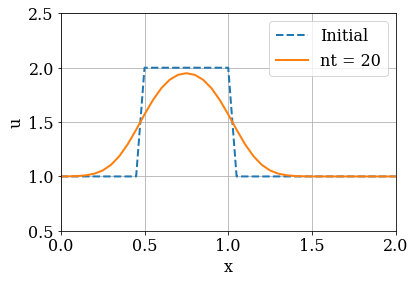

In [5]:
# Plot the solution after nt time steps
# along with the initial conditions.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('x')
pyplot.ylabel('u')
pyplot.grid()
pyplot.plot(x, u0, label='Initial',
            color='C0', linestyle='--', linewidth=2)
pyplot.plot(x, u, label='nt = {}'.format(nt),
            color='C1', linestyle='-', linewidth=2)
pyplot.legend(loc='upper right')
pyplot.xlim(0.0, L)
pyplot.ylim(0.5, 2.5);

## Animations

Looking at before-and-after plots of the wave in motion is helpful, but it's even better if we can see it changing! 

First, let's import the `animation` module of `matplotlib` as well as a special IPython display method called `HTML` (more on this in a bit).

##### Note

You will also have to install a video encoder/decoder named `ffmpeg`.

If you use Linux or OSX, you can install ffmpeg using conda:
```
conda install -c conda-forge ffmpeg
```

If you use Windows, installation instructions can be found [here](http://adaptivesamples.com/how-to-install-ffmpeg-on-windows/).

In [6]:
from matplotlib import animation
from IPython.display import HTML

We are going to create an animation.
This takes a few steps, but it's actually not hard to do!

First, we define a function, called `diffusion`, that computes the numerical solution of the 1D diffusion equation over the time steps.
(The function returns a list with `nt` elements, each one being a Numpy array.)

In [7]:
def diffusion(u0, sigma=0.5, nt=20):
    """
    Computes the numerical solution of the 1D diffusion equation
    over the time steps.
    
    Parameters
    ----------
    u0 : numpy.ndarray
        The initial conditions as a 1D array of floats.
    sigma : float, optional
        The value of nu * dt / dx^2;
        default: 0.5.
    nt : integer, optional
        The number of time steps to compute;
        default: 20.
    
    Returns
    -------
    u_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    u_hist = [u0.copy()]
    u = u0.copy()
    for n in range(nt):
        u[1:-1] = u[1:-1] + sigma * (u[2:] - 2 * u[1:-1] + u[:-2])
        u_hist.append(u.copy())
    return u_hist

We now call the function to store the history of the solution:

In [8]:
# Compute the history of the numerical solution.
u_hist = diffusion(u0, sigma=sigma, nt=nt)

Next, we create a Matplotlib figure that we want to animate.
For now, the figure contains the initial solution (our top-hat function).

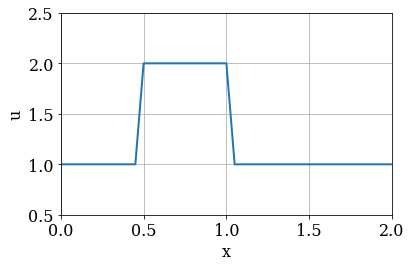

In [9]:
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('x')
pyplot.ylabel('u')
pyplot.grid()
line = pyplot.plot(x, u0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(0.5, 2.5)
fig.tight_layout()

**Note**: `pyplot.plot()` can (optionally) return several values. Since we're only creating one line, we ask it for the "zeroth" (and only...) line by adding `[0]` after the `pyplot.plot()` call.

Now that our figure is initialized, we define a function `update_plot` to update the data of the line plot based on the time-step index.

In [10]:
def update_plot(n, u_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    u_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(u_hist[n])

Next, we create an `animation.FuncAnimation` object with the following arguments:

* `fig`: the name of our figure,
* `diffusion`: the name of our solver function,
* `frames`: the number of frames to dra (which we set equal to `nt`),
* `fargs`: extra arguments to pass to the function `diffusion`,
* `interval`: the number of milliseconds each frame appears for.

In [11]:
# Create an animation.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(u_hist,),
                               interval=100)

Ok! Time to display the animation.
We use the `HTML` display method that we imported above and the `to_html5_video` method of the animation object to make it web compatible.

In [12]:
# Display the video.
HTML(anim.to_html5_video())

---

###### The cell below loads the style of the notebook.

In [13]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())